# Kaggle比赛实战：预测房价

## 载入数据

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下载数据函数

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

解压和缓存到内存

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

kaggle竞赛地址：[https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import d2l_source.d2l as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

加载下载数据

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...


查看数据形状

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


具体的特征 前四个和后两个

In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


或者是全部

In [9]:
print(train_data.iloc[0:4])

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml  

删除第一个特征`ID`

In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [12]:
print(all_features.iloc[0:4])

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
1         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
3         Lvl    AllPub    Corner  ...           0        0    NaN   NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       2    2008        WD         Normal  
1         NaN       0       5    2007        WD         Normal  
2         NaN       0       9    2008        WD         Normal  
3       

## 数据预处理

In [13]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [34]:
print(all_features.iloc[0:4])

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
1   -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
2    0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
3    0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_Oth  \
0      0.896679    0.523038    0.580708    -0.29303  ...             0   
1     -0.395536   -0.569893    1.177709    -0.29303  ...             0   
2      0.848819    0.333448    0.097840    -0.29303  ...             0   
3     -0.682695   -0.569893   -0.494771    -0.29303  ...             0   

   SaleType_WD  SaleType_nan  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0            1             0                      0                      0   
1            1             0                      0                      0   
2        

处理离散值

In [14]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

numpy to tensor

In [15]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 训练

In [16]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [17]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

使用Adam优化器训练

In [18]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

k折交叉验证

In [19]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练验证误差平均值

In [21]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

参数优化

初始
```python
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
```

折1，训练log rmse0.169570, 验证log rmse0.156744
折2，训练log rmse0.162604, 验证log rmse0.193489
折3，训练log rmse0.163755, 验证log rmse0.168296
折4，训练log rmse0.168423, 验证log rmse0.154737
折5，训练log rmse0.162890, 验证log rmse0.182721
5-折验证: 平均训练log rmse: 0.165448, 平均验证log rmse: 0.171197


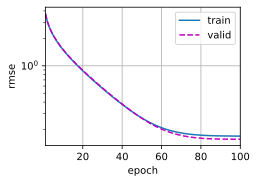

In [22]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.127692, 验证log rmse0.146446
折2，训练log rmse0.130292, 验证log rmse0.120503
折3，训练log rmse0.124925, 验证log rmse0.158385
折4，训练log rmse0.123927, 验证log rmse0.154815
折5，训练log rmse0.129304, 验证log rmse0.121474
折6，训练log rmse0.130048, 验证log rmse0.130990
折7，训练log rmse0.128948, 验证log rmse0.160575
折8，训练log rmse0.124760, 验证log rmse0.174760
8-折验证: 平均训练log rmse: 0.127487, 平均验证log rmse: 0.145994


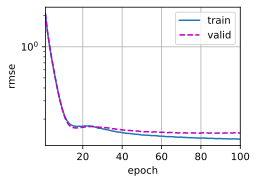

In [58]:
k, num_epochs, lr, weight_decay, batch_size = 8, 100, 25, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

提交结果

In [59]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.126638


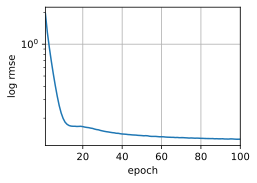

In [60]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

## 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

# 加州房价预测

网址：[https://www.kaggle.com/c/california-house-price/overview](https://www.kaggle.com/c/california-house-price/overview)

## 一些分析


- 集成学习常用在刷榜
- 特征预处理和超参数是取得很好的成绩的基础
- 难点
  - 数值大->大正数取log,归一化
  - 文本特征（地址介绍）->transformer

## automl
- 数据科学家80%时间在处理数据，20%调模型
- Automl现在能处理一些基础的的情况
  - 节省10%时间，未来20%
- 为什么要学习模型